# Algoritmo de clasificacion de canciones

26 Febrero 2018

Alonso Jesús Aguirre Tobar

## Desafio

1. Analiza los dataset data_todotipo.csv y data_reggaeton.csv. ¿Qué puedes decir de los datos,
distribuciones, missing, etc? ¿En qué se diferencian? Entregable: texto/imágenes.
2. Consolida los dos datasets en uno solo y genera una marca para las canciones que sean
reggaeton en base a los datasets. Entregable: csv con dataset y código (si es que usaste).
3. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para detectar qué
canciones son reggaeton. Entregable: modelo en cualquier formato y código (si es que
usaste).
4. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usas para evaluar esa
performance? ¿Por qué elegiste ese algoritmo en particular? ¿Cómo podrías mejorar la
performance​ ? Entregable: texto/imágenes.
5. Aplica tu modelo sobre el dataset “data_test.csv”, agregándole a cada registro dos nuevos
campos: marca_reggaeton (un 1 cuando es reggaetón, un 0 cuando no lo es) y
probabilidad_reggaeton (probabilidad de que la canción sea reggaeton). ¿Cómo elegiste
cuáles marcar? ¿De qué depende que predigas la existencia de mayor o menor cantidad de
reggaetones? Entregable: texto/imágenes.

## Informacion del dataset

Como dice el título, vamos a hacer un detector de reggaetones. Para eso armamos un dataset usando
la API de Spotify, que nos da información detallada de cada canción (documentación). Para cada
canción se tienen los siguientes parámetros:  acousticness, danceability, duration_ms, energy,
instrumentalness, key, liveness, loudness, mode, speechiness, tempo y  time_signature.
Encontrarás tres archivos,
● data_todotipo.csv tiene canciones NO reggaeton.
● data_reggaeton.csv tiene SOLO canciones reggaeton.
● data_test.csv será el dataset para testear la solución.

### Importar las librerías requeridas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

### Pregunta 1 y 2

Se leen los datos y se revisa los missing values, datos NaN (elimine la columna 'id_new' puesto que tiene la misma correlacion con 'Unnamed: 0')

In [2]:
df = pd.read_csv('data_todotipo.csv')
df = df.drop(columns='id_new')
df.isnull().sum()

Unnamed: 0          0
popularity          1
danceability        8
energy              8
key                 8
loudness            8
mode                8
speechiness         8
acousticness        8
instrumentalness    8
liveness            8
valence             8
tempo               8
duration            8
time_signature      8
dtype: int64

Una vez identificadas las columnas que contienen valores NaN se reemplazaron por la media o mediana dependiendo del caso (el criterio para elegir una fue utilizar df.describe(), donde me entregaba la desviacion estandar, asi las columnas con mayor desviacion estandar se reemplazaron los NaN por la media. En cambio las columnas que tenian poca desviacion estandar se reemplazaron los NaN por la mediana).

In [3]:
df['popularity'].fillna(df['popularity'].mean(), inplace = True)
df['danceability'].fillna(df['danceability'].median(), inplace = True)
df['energy'].fillna(df['energy'].median(), inplace = True)
df['key'].fillna(df['key'].mean(), inplace = True)
df['loudness'].fillna(df['loudness'].mean(), inplace = True)
df['mode'].fillna(df['mode'].median(), inplace = True)
df['speechiness'].fillna(df['speechiness'].median(), inplace = True)
df['acousticness'].fillna(df['acousticness'].median(), inplace = True)
df['instrumentalness'].fillna(df['instrumentalness'].median(), inplace = True)
df['liveness'].fillna(df['liveness'].median(), inplace = True)
df['valence'].fillna(df['valence'].median(), inplace = True)
df['tempo'].fillna(df['tempo'].mean(), inplace = True)
df['duration'].fillna(df['duration'].mean(), inplace = True)
df['time_signature'].fillna(df['time_signature'].median(), inplace = True)
df['class'] = np.array([0]*len(df))


Se agrego una columna 'class' para clasificar si es (1) o no es (0) una cancion de Reggaeton, puesto que el primer archivo es exclusivamente de canciones que no son de reggaeton; se creo un vector con solo '0'. Verificamos ademas los valores nulos del mismo DataFrame

In [4]:
df.isnull().sum()

Unnamed: 0          0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
time_signature      0
class               0
dtype: int64

In [5]:
df.describe()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,class
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.0
mean,1115.500000,51.938537,0.566484,0.607492,5.175518,-9.641344,0.598206,0.067641,0.345921,0.214445,0.179408,0.530877,118.338830,233872.923042,3.903139,0.0
std,643.889872,17.636815,0.165591,0.281816,3.513452,6.130354,0.490371,0.063383,0.360210,0.351168,0.153859,0.274594,28.476074,77804.499142,0.390027,0.0
min,1.000000,0.000000,0.062700,0.001810,0.000000,-42.117000,0.000000,0.023100,0.000002,0.000000,0.018000,0.027900,33.579000,46667.000000,1.000000,0.0
25%,558.250000,42.000000,0.456000,0.407500,2.000000,-11.302250,0.000000,0.035525,0.021650,0.000005,0.089725,0.298000,97.445750,187240.000000,4.000000,0.0
50%,1115.500000,56.000000,0.579000,0.671000,5.000000,-8.047000,1.000000,0.045700,0.189000,0.001660,0.118500,0.538500,117.996500,225493.000000,4.000000,0.0
75%,1672.750000,64.000000,0.690000,0.847000,8.000000,-5.703750,1.000000,0.069900,0.664000,0.321000,0.217000,0.766000,133.849750,272103.000000,4.000000,0.0
max,2230.000000,98.000000,0.942000,0.998000,11.000000,-0.282000,1.000000,0.668000,0.996000,0.985000,0.978000,0.982000,211.893000,768507.000000,5.000000,0.0


La cantidad de datos es 2230, y la media de la columna 'class' es 0, es logico puesto que es una columna de ceros.

Se lee el siguiente archivo y se agrega la coluna que permite clasificar si es o no es una cancion de reggaeton, puesto que el archivo es unicamente canciones de reggaeton; se creo un arreglo de valores 1 con longitud del DataFrame

In [6]:
df2 = pd.read_csv('data_reggaeton.csv')
df2['class'] = np.array([1]*len(df2))

In [7]:
df.isnull().sum()

Unnamed: 0          0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
time_signature      0
class               0
dtype: int64

No hay valores nulos, entonces seguimos con la exploracion de datos

In [8]:
df2.describe()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new,class
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,7.000000e+01,70.000000,70.0
mean,35.500000,56.957143,0.776000,0.778171,5.600000,-6.327571,0.571429,0.120620,0.158725,0.005461,0.189397,0.702671,105.910286,2.756467e+05,35.500000,1.0
std,20.351085,10.703427,0.080724,0.097774,3.696453,2.243060,0.498445,0.075096,0.132574,0.029874,0.128542,0.152090,28.554854,2.575437e+05,20.351085,0.0
min,1.000000,27.000000,0.503000,0.533000,0.000000,-13.268000,0.000000,0.032000,0.001650,0.000000,0.035400,0.354000,84.012000,1.516670e+05,1.000000,1.0
25%,18.250000,52.250000,0.743250,0.700250,1.000000,-7.128750,0.000000,0.064375,0.056025,0.000000,0.094475,0.582250,93.993500,1.964132e+05,18.250000,1.0
50%,35.500000,59.000000,0.792000,0.790000,6.500000,-6.031000,1.000000,0.090600,0.113000,0.000001,0.141000,0.722500,95.018500,2.195305e+05,35.500000,1.0
75%,52.750000,63.000000,0.827500,0.863500,9.000000,-4.959750,1.000000,0.161000,0.243500,0.000019,0.262500,0.830250,102.277750,2.509098e+05,52.750000,1.0
max,70.000000,75.000000,0.944000,0.946000,11.000000,-0.262000,1.000000,0.308000,0.563000,0.243000,0.776000,0.966000,214.058000,1.499600e+06,70.000000,1.0


La cantidad de canciones es de 70.
Se combinaron los dos dataset, y se eliminaron las columnas que eran exclusivas de cada dataset. Se guardo el archivo en formato csv (sera adjuntado en el mail)

In [9]:
df3 = pd.merge(df, df2, how='outer')
df3 = df3.drop(columns='id_new')
df3 = df3.drop(columns='time_signature')
np.savetxt("output.csv", df3, fmt="%f", delimiter=",")

Para analizar los graficos se contrarrestaron en un mismo grafico las canciones que son y no son de Reggaeton, si bien es cierto es dificil distinguir la distribucion de las canciones de reggaeton por su notoria diferencia de numero de canciones, en general es muy utilizada esta forma de exponer los datos porque compara directamente las distintas distribuciones de datos.

/home/dahaka/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


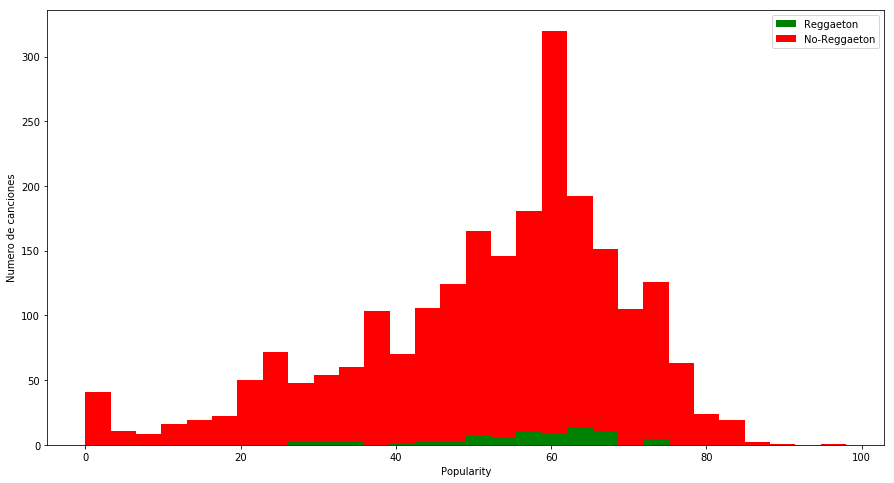

In [10]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['popularity'],df3[df3['class']==0]['popularity']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Popularity')
plt.ylabel('Numero de canciones')
plt.legend()

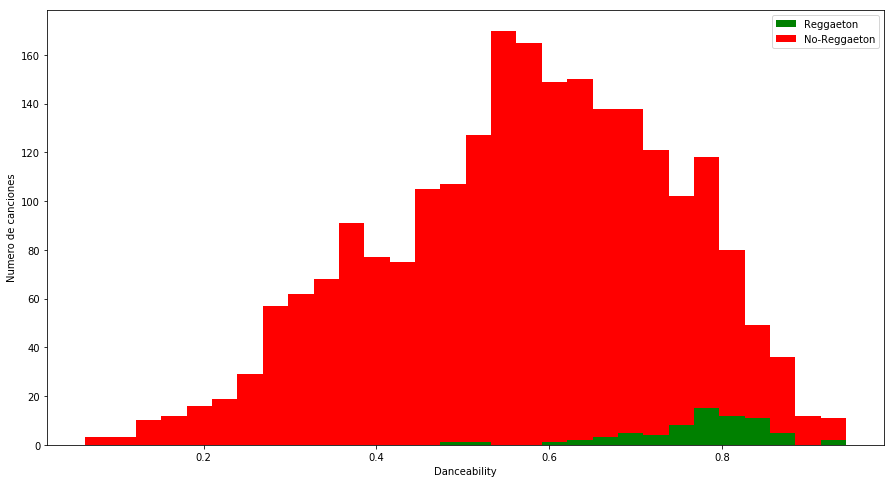

In [11]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['danceability'],df3[df3['class']==0]['danceability']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Danceability')
plt.ylabel('Numero de canciones')
plt.legend()

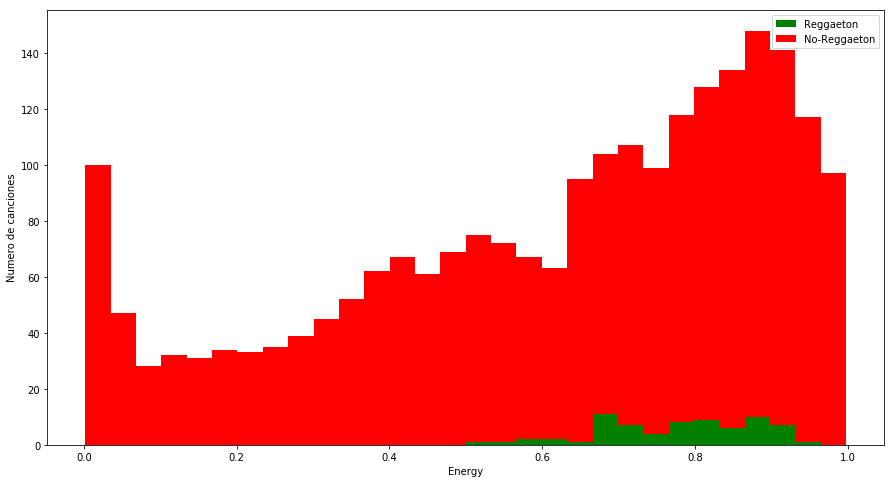

In [12]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['energy'],df3[df3['class']==0]['energy']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Energy')
plt.ylabel('Numero de canciones')
plt.legend()

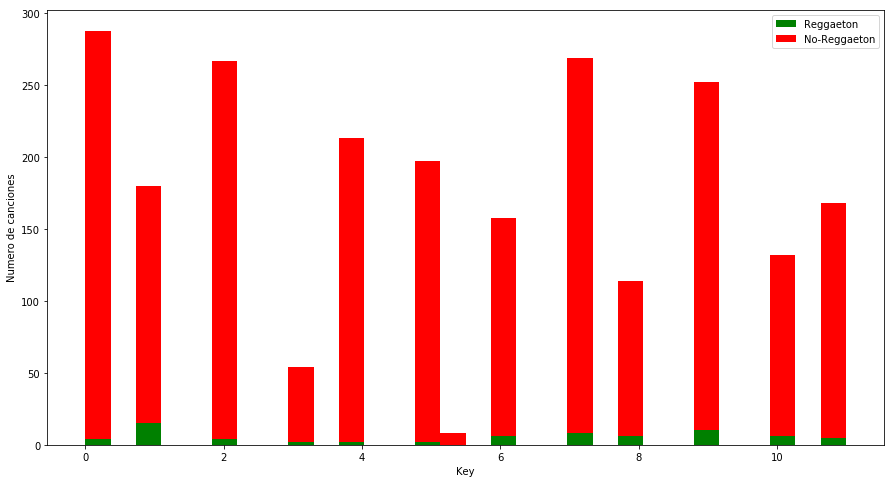

In [13]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['key'],df3[df3['class']==0]['key']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Key')
plt.ylabel('Numero de canciones')
plt.legend()

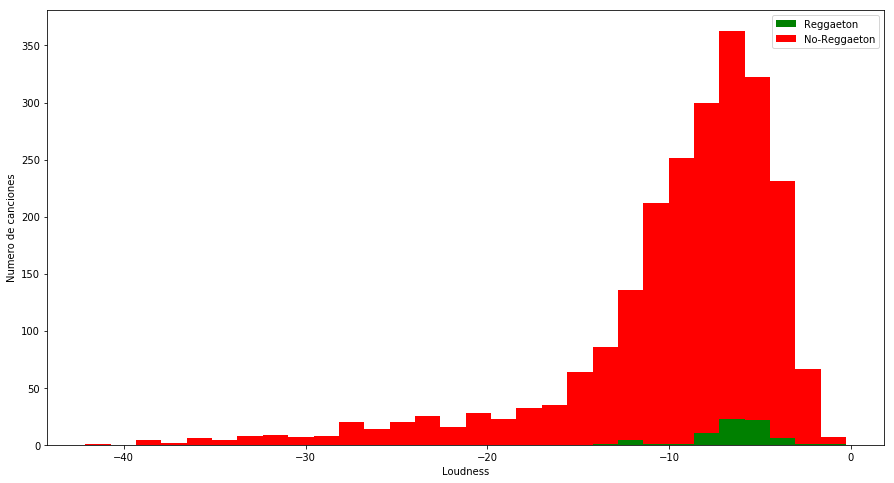

In [14]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['loudness'],df3[df3['class']==0]['loudness']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Loudness')
plt.ylabel('Numero de canciones')
plt.legend()

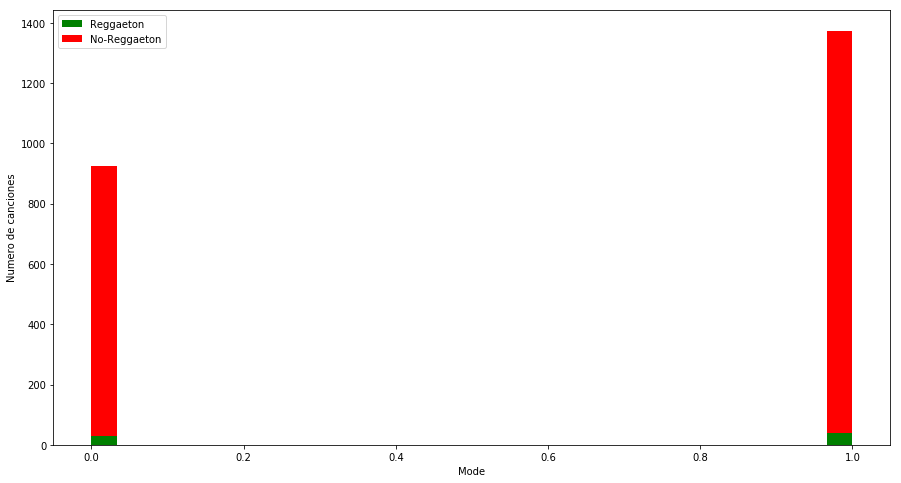

In [15]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['mode'],df3[df3['class']==0]['mode']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Mode')
plt.ylabel('Numero de canciones')
plt.legend()

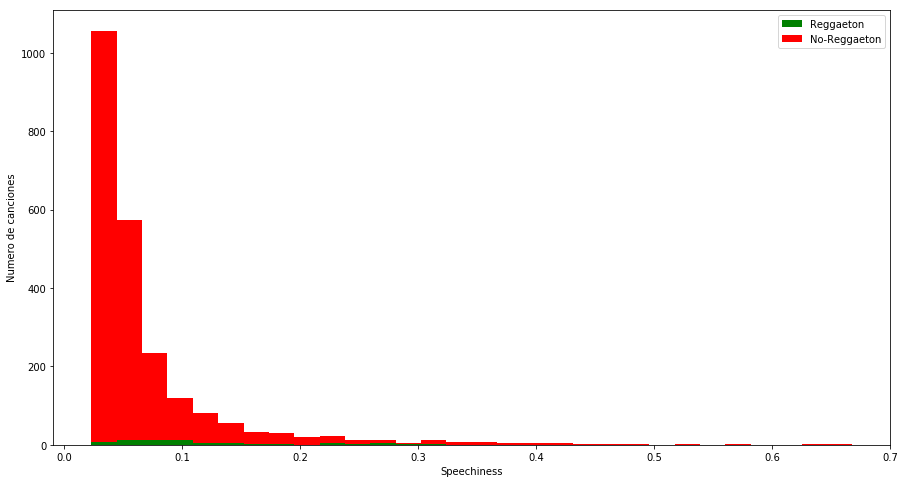

In [16]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['speechiness'],df3[df3['class']==0]['speechiness']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Speechiness')
plt.ylabel('Numero de canciones')
plt.legend()

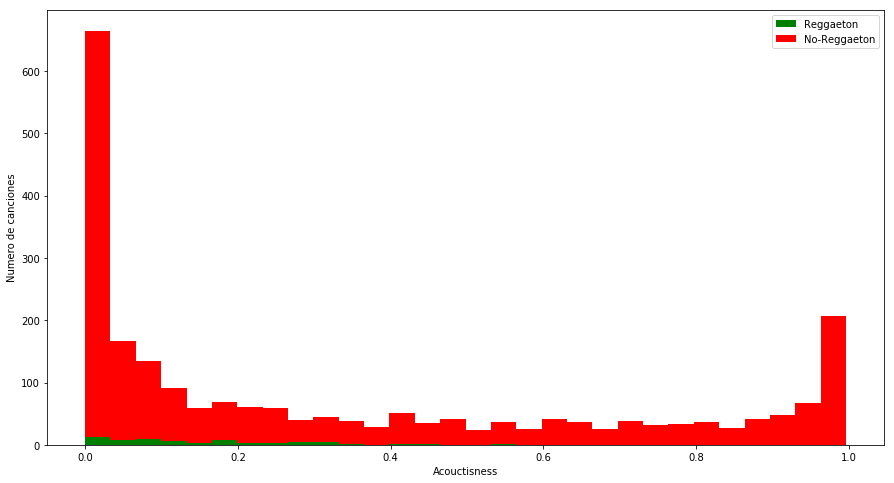

In [17]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['acousticness'],df3[df3['class']==0]['acousticness']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Acouctisness')
plt.ylabel('Numero de canciones')
plt.legend()

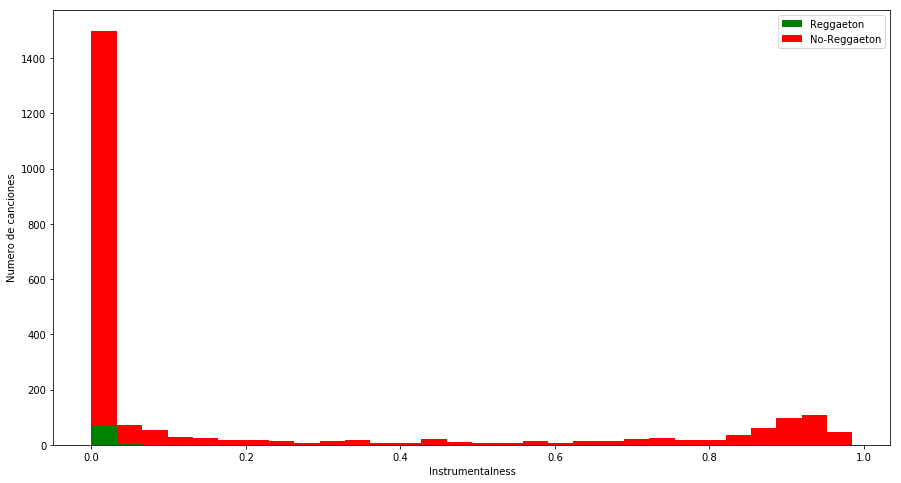

In [18]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['instrumentalness'],df3[df3['class']==0]['instrumentalness']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Instrumentalness')
plt.ylabel('Numero de canciones')
plt.legend()

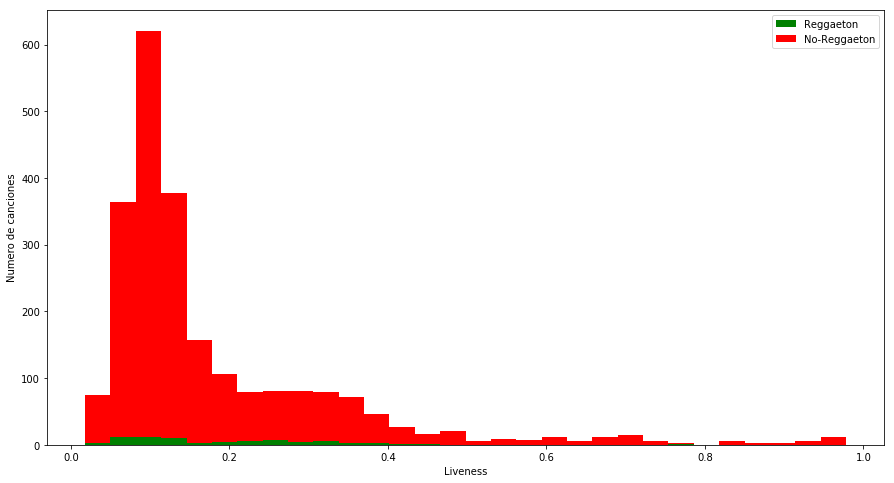

In [19]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['liveness'],df3[df3['class']==0]['liveness']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Liveness')
plt.ylabel('Numero de canciones')
plt.legend()

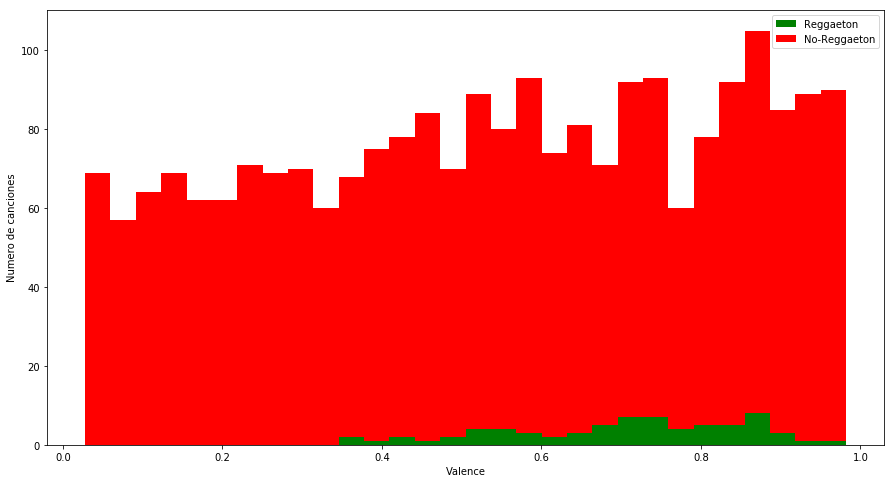

In [20]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['valence'],df3[df3['class']==0]['valence']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Valence')
plt.ylabel('Numero de canciones')
plt.legend()

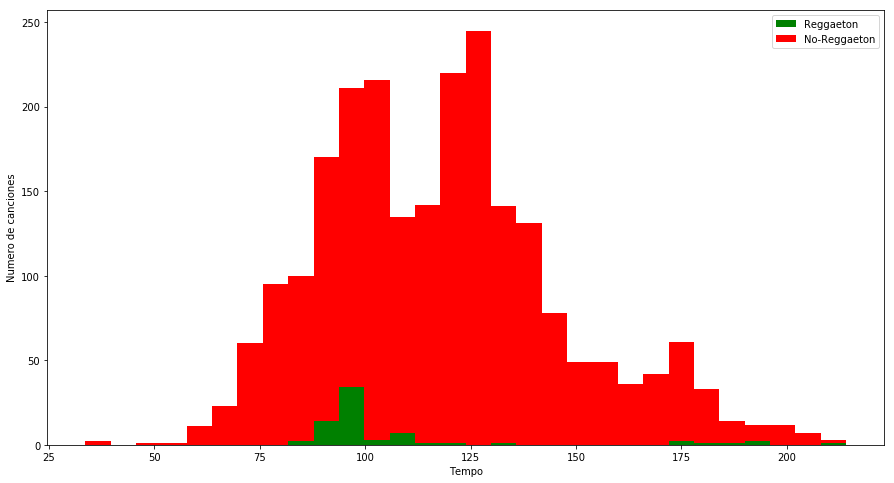

In [21]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['tempo'],df3[df3['class']==0]['tempo']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Tempo')
plt.ylabel('Numero de canciones')
plt.legend()

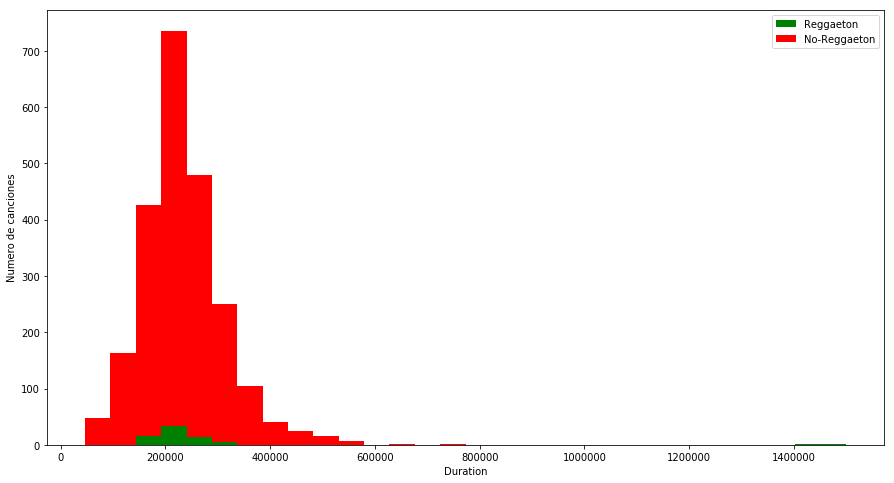

In [22]:
figure = plt.figure(figsize=(15,8))
plt.hist([df3[df3['class']==1]['duration'],df3[df3['class']==0]['duration']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Reggaeton','No-Reggaeton'])
plt.xlabel('Duration')
plt.ylabel('Numero de canciones')
plt.legend()

### Diferenciacion de los dataset

Dado los graficos de mas arriba se aprecia que ciertas features se distribuyen de forma distinta, esto quiere decir que esas features son predominantes para clasificar si una cancion es o no una cancion de reggaeton... una forma rapida pero bastante simple es comparar la media con su incertidumbre correspondiente, determinada por la desviacion estandar y el numero de observaciones. Estos datos estadisticos se visualizan usando df.describe(), si bien es cierto la media de por ejemplo 'popularity' se distingue con claridad, pero la incertidumbre complica la comparativa dada la gran diferencia de observaciones, esto provoca que las canciones de reggaeton tengan una alta incertidumbre. Es por esta razon que se busca un modelo predictivo, para que no solo compare una sola feature, sino que con un algoritmo incluya todas las variantes en juego, asi tener una mayor precision a la hora de clasificar las canciones.

### Pregunta 3 y 4

Creamos los modelos predictivos, para se uso el dataset 'df3' que contiene los dataset combinados. Definimos las variables que seran entrenadas,  escalamos los valores de X para tener una variable aleatoria, y una proyeccion de los datos. Usamos KFold y Cross Validation para evitar un sobre-entrenamiento de datos.

In [23]:
X = np.array(df3.drop('class', axis=1))
X = StandardScaler().fit_transform(X)
y = np.array(df3['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
def accuracy(model):
    kf = KFold(n_splits=5)
    crv = cross_val_score(model, X_train, y_train, cv=kf,scoring='accuracy')
   
    return crv.mean()*100

accuracy(LogisticRegression())

98.95652173913044

Se obtuvo la presicion del modelo de Logistic Regression, e incluimos ademas los modelos Random Forest y Support Vector Machine, para compararlos. Se uso ademas la matriz confusion, dado que entrega diversas herramientas para comparar la precision de cada modelo en base a la veracidad de los datos.

In [24]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
clf.score(X_test, y_test)*100

con = confusion_matrix(y_test, clf.predict(X_test))
print(classification_report(y_test, clf.predict(X_test)))




             precision    recall  f1-score   support

          0       0.99      0.99      0.99       556
          1       0.80      0.63      0.71        19

avg / total       0.98      0.98      0.98       575



In [25]:
accuracy(RandomForestClassifier())

98.84057971014494

In [26]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
clf.score(X_test, y_test)*100

con = confusion_matrix(y_test, clf.predict(X_test))
print(classification_report(y_test, clf.predict(X_test)))




             precision    recall  f1-score   support

          0       0.99      1.00      0.99       556
          1       1.00      0.58      0.73        19

avg / total       0.99      0.99      0.98       575



Para usar el modelo de SVM analizamos las features que sean mas determinantes 

In [27]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
C = clf.feature_importances_
for i in range(len((C))):
    print(df.columns[i], ': ', C[i]*100)

('Unnamed: 0', ': ', 47.48586986490213)
('popularity', ': ', 0.0)
('danceability', ': ', 3.6585870907502818)
('energy', ': ', 0.0)
('key', ': ', 0.0)
('loudness', ': ', 1.8650967417570823)
('mode', ': ', 0.0)
('speechiness', ': ', 0.0)
('acousticness', ': ', 0.0)
('instrumentalness', ': ', 24.985688997977046)
('liveness', ': ', 0.0)
('valence', ': ', 19.499723032840237)
('tempo', ': ', 2.5050342717732237)
('duration', ': ', 0.0)


In [28]:
X = np.array(df3[['Unnamed: 0','instrumentalness','valence','tempo']])
X = StandardScaler().fit_transform(X)
y = np.array(df3['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
accuracy(SVC(kernel='linear', C=0.1))

97.33695652173913

In [29]:
clf = SVC(kernel='linear', C=0.1)
clf.fit(X_train,y_train)
clf.score(X_test, y_test)*100

con = confusion_matrix(y_test, clf.predict(X_test))
print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98       439
          1       0.00      0.00      0.00        21

avg / total       0.91      0.95      0.93       460



/home/dahaka/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Se elegio el modelo Logistic Regression, porque se adapto mejor al comportamiento de los datos. Se que hay muchas formas de comparar modelo, de hecho con la experiencia se puede saber la tendencia de los datos, y asi determinar el modelo a utilizar, sin embargo es fundamental una comparacion de la presicion de cada modelo, porque no todos los problemas son intuitivos.

### Pregunta 5

Dado el modelo predictivo elegido se usa para clasificar un nuevo data set. Para se utilizo el escalamiento que entreno los datos de  'df3' (La combinacion de los dos primeros dataset). Se ingreso el nuevo dataset como 'dft', y se ajustaron los datos del nuevo dataset con el escalamiento de entrenamiento. 

In [30]:
X = np.array(df3.drop('class', axis=1))
y = np.array(df3['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

dft = pd.read_csv('data_test.csv')
dft = dft.drop(columns='id_new')
dft = dft.drop(columns='time_signature')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
new_data = np.array(dft)
new_data_scaled = scaler.transform(new_data)

def accuracy(model):
    kf = KFold(n_splits=5)
    crv = cross_val_score(model, X_train, y_train, cv=kf,scoring='accuracy')
   
    return crv.mean()*100


clf = LogisticRegression()
clf.fit(X_train,y_train)
clf.predict(new_data_scaled)

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0])

Por utlimo se creo una columna 'new_class' que representa la clasificacion que es predecida al evaluar nuestro modelo. Esta columna se adjunto al nuevo dataset 'dft'

In [31]:
dft['new_class'] = clf.predict(new_data_scaled)
dft.head()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,new_class
0,1,60,0.607,0.875,0,-4.434,1,0.0605,0.00114,0.007650,0.4670,0.4570,131.058,264520,0
1,2,69,0.757,0.868,9,-9.326,1,0.0620,0.41100,0.002210,0.3550,0.8150,138.923,199200,0
2,3,88,0.791,0.866,6,-4.236,1,0.0497,0.24800,0.000005,0.0696,0.7100,96.011,217080,1
3,4,70,0.589,0.484,7,-6.622,1,0.0266,0.48900,0.000000,0.1130,0.0927,120.258,269973,0
4,5,61,0.617,0.771,10,-5.586,0,0.1120,0.03840,0.000003,0.1620,0.5530,180.002,267747,0


In [32]:
dft.describe()

,Unnamed: 0,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,new_class
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,25.50000,66.880000,0.602540,0.709012,5.820000,-7.498040,0.560000,0.067878,0.232484,0.115466,0.138906,0.544072,121.36682,247553.980000,0.200000
std,14.57738,14.963411,0.165037,0.236425,3.509113,5.384327,0.501427,0.046266,0.288131,0.282794,0.114767,0.273260,33.26185,65363.087448,0.404061
min,1.00000,31.000000,0.143000,0.011800,0.000000,-28.011000,0.000000,0.026600,0.000068,0.000000,0.042400,0.065900,57.83200,127920.000000,0.000000
25%,13.25000,60.000000,0.502000,0.662500,2.500000,-7.391000,0.000000,0.038950,0.037800,0.000000,0.071650,0.323750,96.25550,204295.250000,0.000000
50%,25.50000,70.000000,0.623000,0.775500,6.500000,-6.244000,1.000000,0.050100,0.108500,0.000044,0.103000,0.573000,111.32150,250097.000000,0.000000
75%,37.75000,76.000000,0.743000,0.867500,9.000000,-4.285500,1.000000,0.077975,0.348000,0.004095,0.132500,0.789000,135.62550,271340.250000,0.000000
max,50.00000,92.000000,0.868000,0.972000,11.000000,-2.965000,1.000000,0.236000,0.989000,0.943000,0.515000,0.965000,198.05000,564240.000000,1.000000


Los datos estadisticos determinan la media de la columna 'new_class', dando un 20%, o sea que 10 de 50 canciones son de reggaeton.

### Conclusiones

Se realizo un analisis completo de una combinacion de dos dataset, estos dataset clasificaban si una cancion es o no de reggaeton. La combinacion de los dataset se utilizo para diferenciar los dataset y crear un modelo en base a entrenamiento de datos, la precision de los distintos modelos fue buena, alrededor de un 96%. Para determinar que modelo elegir se compararon de diferentes formas su precision encontrando un mejor rendimiento con el modelo de Logistic Regression. Se guardo con una variable el escalamiento usado para el entrenamiento de datos, con ese escalamiento se clasifico  las canciones del nuevo dataset, encontrando ¿ que 10 de 50 canciones son de reggaeton.

Realice este analisis y explique paso por paso las herramientas utilizadas de forma tecnica, tengo claro que uando trabaje en su empresa tendre que resumir y ajustar el lenguaje para un entendimiento simple y claro para la mejor toma de desicion de la gerencia. 

### Referencias

1. https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes
2. https://www.ncbi.nlm.nihgov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf
3. http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
4. https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/
5. https://www.analyticsvidhya.com/blog/2014/10/support-vector-machine-simplified/
6. https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
7. https://relopezbriega.github.io/blog/2015/10/10/machine-learning-con-python/